# Análisis de datos postura: *Tree*

### Calculo de los angulos medios de la postura para determinar el angulo ideal de la postura

## Posture data analysis: *Tree*

#### Calculation of mean stance angles to determine the ideal stance angle

In [54]:
# Import libraries
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt

### Definición de funciones de cálculo de ángulos

#### Definition of angle calculation functions

In [55]:
# Function for calculating the angles
def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [56]:
# Function to calculate the angles of the dataset

def angles_df(points, df, visibility):

    ang_points_coord= [[j+str(i)  for j in ['x', 'y', 'v']] for i in points]
    angle = []

    for j in range(df.shape[0]):
        l = []
        for i in ang_points_coord:
            if df[i[2]][j] > visibility:
                corr = (df[i[0]].iloc[j], df[i[1]].iloc[j])
                l.append(corr)
        if len(l) == 3:
            angle.append(int(calculate_angle_coord(l)))
    
    return angle

### Puntos para calcular el angulo

In [57]:
# Points for calculating the value angle of the middle of each tuple
#'downdog'
p_list = [(11, 23, 25), 
        (12, 24, 26), 
        (23, 25, 27),
        (24, 26, 28)]

![Alt text](..\interface\pages\Data\images_display\Landmarks.png)

### Representación de los puntos en imagen de la postura con su medición del ángulo

#### Representation of points in posture image with their angle measurement

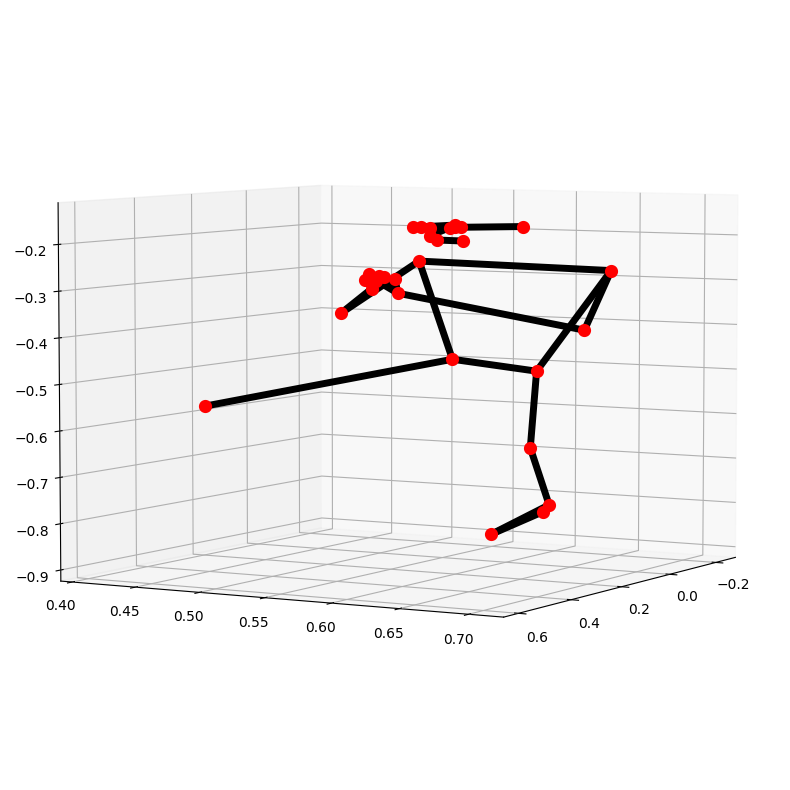

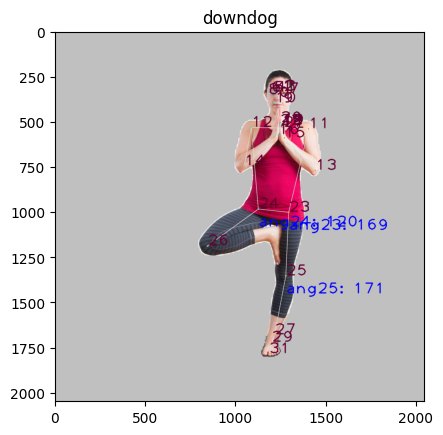

In [58]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:

path = '..\DATASET\TRAIN\\tree\\00000.jpg'
#image = cv2.imread(path)

IMAGE_FILES = [path]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
    landmrk_value = [l.value for l in mp_pose.PoseLandmark]

    text_size = int(round(np.linalg.norm(annotated_image.shape)*0.002,0))

    poses = results.pose_landmarks.landmark
    pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in poses]).flatten())

    for i in landmrk_value:
      if  results.pose_landmarks.landmark[i].visibility > 0.5 : 
        cv2.putText(annotated_image, str(i), (int((results.pose_landmarks.landmark[i].x)*annotated_image.shape[1]) , 
                                              int((results.pose_landmarks.landmark[i].y)*annotated_image.shape[0])),
                    cv2.FONT_HERSHEY_PLAIN, text_size, (50, 0, 100), text_size)
           
    
    for i in range(len(p_list)):
        p_cood_list = []
        midle_point = p_list[i][1]
        for p in p_list[i]:
            if results.pose_landmarks.landmark[p].visibility > 0.5:
                p_corrd = (results.pose_landmarks.landmark[p].x, results.pose_landmarks.landmark[p].y)
                p_cood_list.append(p_corrd)
            else:
                break

        try:
            angle = int(calculate_angle_coord(p_cood_list))
            cv2.putText(annotated_image, str(f'ang{p_list[i][1]}: {angle}'), (int((results.pose_landmarks.landmark[midle_point].x)*annotated_image.shape[1]) , 
                          100+int((results.pose_landmarks.landmark[midle_point].y)*annotated_image.shape[0])),
                          cv2.FONT_HERSHEY_PLAIN, text_size, (255,0,0), text_size)

        except:
            pass
      
   
    
    cv2.imwrite('images/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.

mp_drawing.plot_landmarks(results.pose_landmarks, mp_pose.POSE_CONNECTIONS, elevation = 5, azimuth= 30)

image_pose = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_pose)
plt.title('downdog')
plt.show()

## Carga del dataset

### Load dataset

In [59]:
df_tree_train = pd.read_csv('../coord_dataset_csv/df_tree_train.csv')
df_tree_test = pd.read_csv('../coord_dataset_csv/df_tree_test.csv')
df_tree = pd.concat([df_tree_train, df_tree_test],
                         ignore_index=True)
df_tree

,class,path,x0,y0,z0,v0,x1,y1,z1,v1,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
0,tree,DATASET/TRAIN/tree\00000.jpg,0.604573,0.180202,-0.320164,0.999935,0.613667,0.164100,-0.289335,0.999913,...,0.265519,0.445407,0.578380,0.872307,0.050372,0.968530,0.617118,0.623819,0.237227,0.490836
1,tree,DATASET/TRAIN/tree\00001.jpg,0.518111,0.164856,-0.422319,0.999972,0.532120,0.147761,-0.374591,0.999959,...,0.558625,0.492684,0.551148,0.930632,0.106231,0.962685,0.528213,0.668406,0.531313,0.426155
2,tree,DATASET/TRAIN/tree\00002.jpg,0.560236,0.207913,-0.900815,0.999999,0.574201,0.190650,-0.858605,0.999999,...,0.590444,0.573058,0.544557,0.941869,0.253845,0.970028,0.557439,0.685018,0.544886,0.534285
3,tree,DATASET/TRAIN/tree\00003.jpg,0.546107,0.272420,-0.319493,0.999881,0.551273,0.257274,-0.302622,0.999835,...,0.229980,0.657081,0.528297,0.903298,0.081554,0.952982,0.534348,0.700158,0.210020,0.685977
4,tree,DATASET/TRAIN/tree\00004.jpg,0.542144,0.102548,-0.691471,0.999978,0.558410,0.086861,-0.629081,0.999955,...,0.194372,0.733954,0.511738,0.964464,0.062448,0.978972,0.540802,0.694727,0.030187,0.816087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,tree,DATASET/TEST/tree\00273.jpg,0.511929,0.234913,-0.328165,0.999634,0.521856,0.218898,-0.281794,0.999465,...,0.211505,0.458248,0.489409,0.896413,-0.169417,0.954014,0.518513,0.631313,0.135333,0.503863
274,tree,DATASET/TEST/tree\00274.jpg,0.447190,0.293728,-0.156988,0.999729,0.452070,0.280483,-0.134013,0.999538,...,0.157867,0.921860,0.436497,0.710239,0.024732,0.844501,0.448796,0.933887,0.043676,0.956739
275,tree,DATASET/TEST/tree\00275.jpg,0.501428,0.220597,-0.165073,0.998492,0.506387,0.206152,-0.134691,0.998390,...,0.131574,0.869307,0.497961,0.683981,0.219007,0.398480,0.513709,0.959092,0.010515,0.880040
276,tree,DATASET/TEST/tree\00276.jpg,0.483805,0.299393,-0.097950,0.999387,0.488419,0.289197,-0.079766,0.999324,...,0.074596,0.845589,0.476548,0.619995,0.141903,0.512350,0.489555,0.826626,-0.020197,0.918602


tree


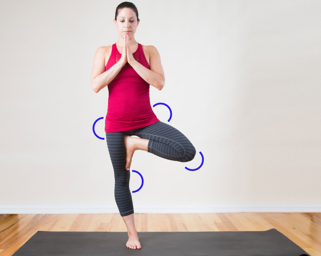

tree_inv


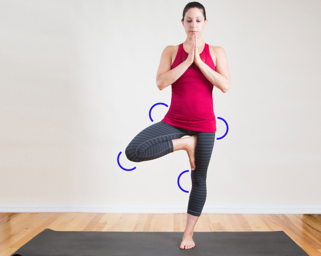

In [60]:
from PIL import Image 
tree_im = Image.open(r"../interface/pages\Data/images_display/Tree.png") 
tree_im_inv = Image.open(r"../interface/pages\Data/images_display/Tree_inv.png") 
scale = 0.3
print('tree')
display(tree_im.resize(( int(tree_im.width * scale), int(tree_im.height * scale))))
print('tree_inv')
display(tree_im_inv.resize(( int(tree_im_inv.width * scale), int(tree_im_inv.height * scale))))

In [61]:
# Minimum visibility
visibility = 0.8

### Análisis de los ángulos en cada punto

#### Analysis of the angles at each point

In [62]:
# Points on the rigth side
ang23_points  = [11,23,25]
ang24_points  = [12,24,26]
ang25_points  = [23,25,27]
ang26_points  = [24,26,28]

#### Punto 23

##### Point 23

In [63]:
ang23_all = pd.DataFrame({'ang23':angles_df(ang23_points, df_tree, visibility)})
ang23_all.count()

ang23    275
dtype: int64

In [64]:
ang23_all['ang23'].sort_values().unique()

array([ 92,  95,  99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110,
       111, 113, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 141, 143,
       157, 158, 160, 161, 162, 163, 165, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179], dtype=int64)

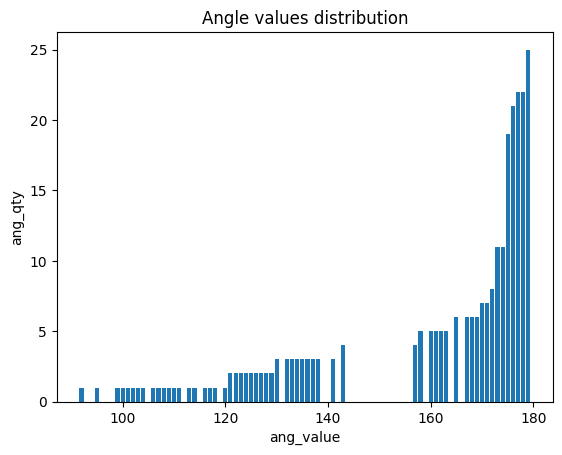

In [65]:
plt.bar(ang23_all['ang23'].sort_values().unique(), ang23_all['ang23'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [66]:
ang23 = ang23_all[ang23_all['ang23'] < 157]
ang23_inv = ang23_all[ang23_all['ang23'] > 157]

ang23.describe()

,ang23
count,101.000000
mean,120.059406
std,12.703403
min,92.000000
25%,110.000000
50%,118.000000
75%,132.000000
max,143.000000


In [67]:
ang23_inv.describe()

,ang23
count,173.000000
mean,174.404624
std,4.160778
min,158.000000
25%,173.000000
50%,176.000000
75%,177.000000
max,179.000000


#### Punto 24

##### Point 24

In [68]:
ang24_all = pd.DataFrame({'ang24':angles_df(ang24_points, df_tree, visibility)})
ang24_all.count()

ang24    277
dtype: int64

In [69]:
ang24_all['ang24'].sort_values().unique()

array([ 94,  97,  98,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 149, 153, 160,
       163, 164, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179],
      dtype=int64)

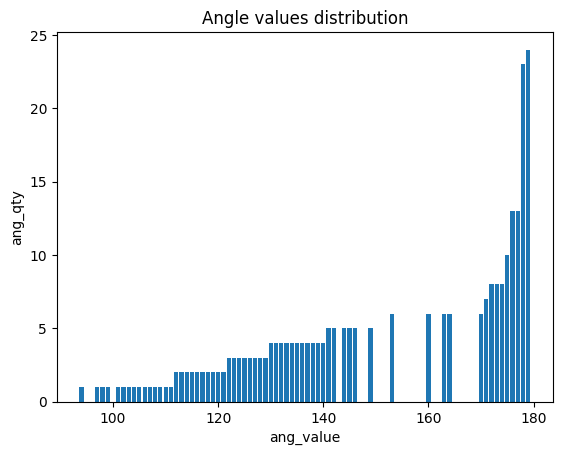

In [70]:
plt.bar(ang24_all['ang24'].sort_values().unique(), ang24_all['ang24'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [71]:
ang24 = ang24_all[ang24_all['ang24'] > 149]
ang24_inv = ang24_all[ang24_all['ang24'] < 149]

ang24.describe()

,ang24
count,109.000000
mean,175.779817
std,3.977617
min,153.000000
25%,175.000000
50%,177.000000
75%,178.000000
max,179.000000


In [72]:
ang24_inv.describe()

,ang24
count,167.000000
mean,121.161677
std,12.630675
min,94.000000
25%,111.000000
50%,120.000000
75%,133.000000
max,146.000000


#### Punto 25

##### Point 25

In [73]:
ang25_all = pd.DataFrame({'ang25':angles_df(ang25_points, df_tree, visibility)})
ang25_all.count()

ang25    177
dtype: int64

In [74]:
ang25_all['ang25'].sort_values().unique()

array([ 23,  36,  43,  47,  54,  74,  85,  94, 158, 164, 165, 167, 168,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179], dtype=int64)

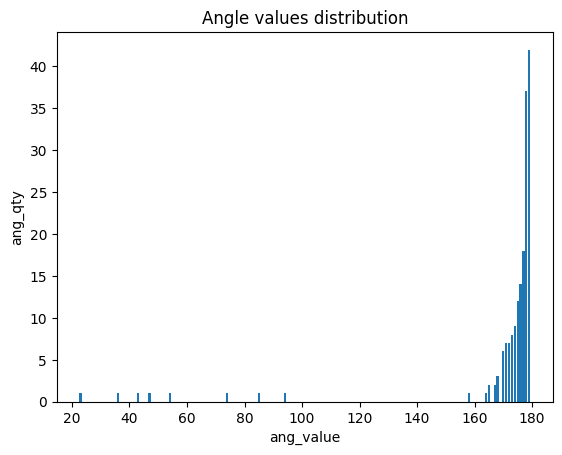

In [75]:
plt.bar(ang25_all['ang25'].sort_values().unique(), ang25_all['ang25'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()


In [76]:
ang25 = ang25_all[ang25_all['ang25'] < 158]
ang25_inv = ang25_all[ang25_all['ang25'] > 158]

ang25.describe()

,ang25
count,8.000000
mean,57.000000
std,24.911271
min,23.000000
25%,41.250000
50%,50.500000
75%,76.750000
max,94.000000


In [77]:
ang25_inv.describe()

,ang25
count,168.000000
mean,175.815476
std,3.579114
min,164.000000
25%,174.000000
50%,177.000000
75%,178.250000
max,179.000000


#### Punto 26

##### Point 26

In [78]:
ang26_all = pd.DataFrame({'ang26':angles_df(ang26_points, df_tree, visibility)})
ang26_all.count()

ang26    127
dtype: int64

In [79]:
ang26_all['ang26'].sort_values().unique()

array([ 22,  23,  24,  28,  41,  45,  51,  55,  58,  60,  64,  77,  84,
        85, 101, 104, 162, 166, 168, 169, 171, 172, 173, 174, 175, 176,
       177, 178, 179], dtype=int64)

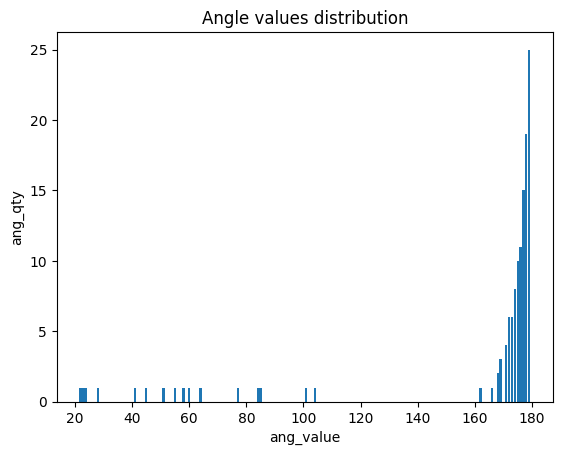

In [80]:
plt.bar(ang26_all['ang26'].sort_values().unique(), ang26_all['ang26'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [81]:
ang26 = ang26_all[ang26_all['ang26'] > 162]
ang26_inv = ang26_all[ang26_all['ang26'] < 162]

ang26.describe()

,ang26
count,106.000000
mean,176.113208
std,2.778560
min,166.000000
25%,175.000000
50%,177.000000
75%,178.000000
max,179.000000


In [82]:
ang26_inv.describe()

,ang26
count,20.000000
mean,56.900000
std,25.239693
min,22.000000
25%,37.750000
50%,59.000000
75%,67.250000
max,104.000000


## Valores medios de los ángulos para cada punto

### Average values of the angles for each point

In [83]:
results = pd.DataFrame({'ang: 23' : (int(ang23.mean().item()), int(ang23_inv.mean().item())), 
                        'ang: 24' : (int(ang24.mean().item()), int(ang24_inv.mean().item())), 
                        'ang: 25' : (int(ang25.mean().item()), int(ang25_inv.mean().item())),
                        'ang: 26' : (int(ang26.mean().item()), int(ang26_inv.mean().item()))},
                        index=['tree', 'tree_inv'])
results

,ang: 23,ang: 24,ang: 25,ang: 26
tree,120,175,57,176
tree_inv,174,121,175,56
